# Time Series Modelling with Transformers

In [24]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

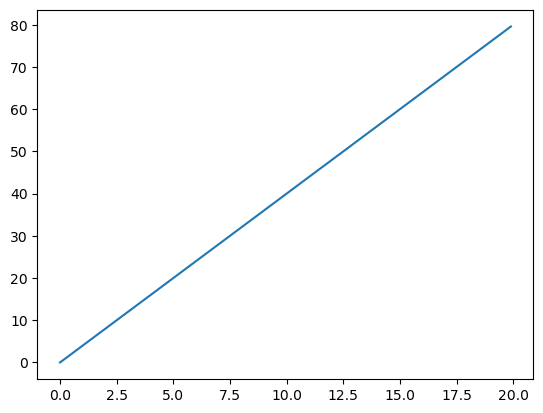

In [20]:
# Create a synthetic time series dataset
def generate_time_series(num_steps, step_size=0.1):
    x = np.arange(0, num_steps * step_size, step_size)
    y = 4 * x # np.sin(x)
    return y

plt.plot(0.1 * np.arange(200), generate_time_series(200))
pass

In [21]:
# Split the time series into input and target sequences, we aim to forecast output_steps number of steps given input_steps number of steps
# Hence we batch into sequences of length input steps and the subsequent number of output steps afterwards
def split_sequences(sequences, input_steps, output_steps):
    X, y = [], []
    for i in range(len(sequences) - input_steps - output_steps + 1):
        X.append(sequences[i:i+input_steps])
        y.append(sequences[i+input_steps:i+input_steps+output_steps])
    return np.array(X), np.array(y)

In [22]:
# Define the transformer model
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, num_heads, num_layers, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads),
            num_layers=num_layers)
        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=output_dim, nhead=num_heads),
            num_layers=num_layers)
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, src, tgt):
        encoder_output = self.encoder(src)
        decoder_output = self.decoder(tgt, encoder_output)
        return self.linear(decoder_output)

In [23]:
# We aim to predict the next 5 data points from the previous 20
input_steps = 20
output_steps = 5

# Our data is one dimensional
input_dim = 1
output_dim = 1

# We are only doing single head attention as the data is one dimensional, so we cannot project to different dimensional latent subspaces and reap the benefits of multi-head attention
num_heads = 1

# Hyper-parameters of our model
num_layers = 5
batch_size = 16
epochs = 50

In [19]:
# Generate and split the dataset
time_series = generate_time_series(200)
X, y = split_sequences(time_series, input_steps, output_steps)
X = X.reshape(-1, input_steps, input_dim)
y = y.reshape(-1, output_steps, output_dim)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Create DataLoader
dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instantiate the model
model = TimeSeriesTransformer(input_dim, output_dim, num_heads, num_layers)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Train the model
for epoch in range(epochs):
    for batch_X, batch_y in dataloader:
        batch_X = batch_X.permute(1, 0, 2)
        batch_y = batch_y.permute(1, 0, 2)
        optimizer.zero_grad()
        outputs = model(batch_X, batch_y)
        loss = loss_fn(outputs, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

Epoch 1/50, Loss: 2569.032958984375
Epoch 2/50, Loss: 2117.983642578125
Epoch 3/50, Loss: 1672.5367431640625
Epoch 4/50, Loss: 1974.8486328125
Epoch 5/50, Loss: 3002.206298828125
Epoch 6/50, Loss: 2484.0849609375
Epoch 7/50, Loss: 2436.470703125
Epoch 8/50, Loss: 3145.45068359375
Epoch 9/50, Loss: 1864.061279296875
Epoch 10/50, Loss: 2559.61767578125
Epoch 11/50, Loss: 2158.922607421875
Epoch 12/50, Loss: 2097.955078125
Epoch 13/50, Loss: 1854.310546875
Epoch 14/50, Loss: 2178.5263671875
Epoch 15/50, Loss: 2473.83447265625
Epoch 16/50, Loss: 1998.099609375
Epoch 17/50, Loss: 2272.98779296875
Epoch 18/50, Loss: 2131.326904296875
Epoch 19/50, Loss: 2445.550048828125
Epoch 20/50, Loss: 2006.182373046875
Epoch 21/50, Loss: 2618.9267578125
Epoch 22/50, Loss: 2073.98974609375
Epoch 23/50, Loss: 2021.552734375
Epoch 24/50, Loss: 2164.57275390625
Epoch 25/50, Loss: 2571.428955078125
Epoch 26/50, Loss: 2282.541259765625
Epoch 27/50, Loss: 3012.181640625
Epoch 28/50, Loss: 2448.3662109375
Epoch 

In [13]:
# Evaluate the model
model.eval()
test_seq = time_series[:input_steps].reshape(-1, input_dim)
predictions = []

In [14]:
for i in range(output_steps):
    input_seq = torch.tensor(test_seq[-input_steps:].reshape(1, input_steps, input_dim), dtype=torch.float32)
    with torch.no_grad():
        output = model(input_seq.permute(1, 0, 2), input_seq.permute(1, 0, 2))
    prediction = output[0, -1, 0].item()
    predictions.append(prediction)
    test_seq = np.append(test_seq, prediction)

tensor([[[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]]])
tensor([[[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]]])
tensor([[[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8570]],

        [[0.8

5
[0.85703444480896, 0.85703444480896, 0.85703444480896, 0.85703444480896, 0.85703444480896]


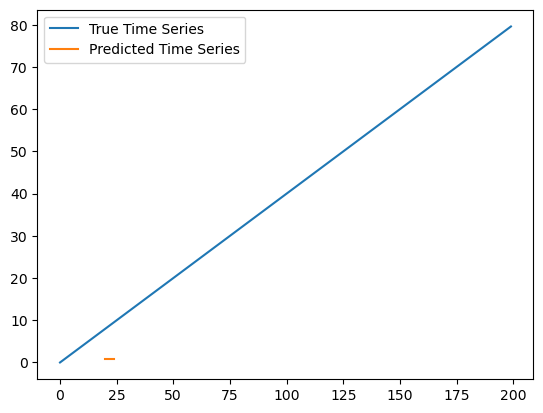

In [15]:
print(len(predictions))
print(predictions)
# Plot the results
plt.plot(time_series, label="True Time Series")
plt.plot(range(input_steps, input_steps + output_steps), predictions, label="Predicted Time Series")
plt.legend()
plt.show()
